<a href="https://colab.research.google.com/github/riccardorampon/LANL-Earthquake-Prediction/blob/main/Earthquake_Acustic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost

In [3]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [8]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [9]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         36           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        141           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        847           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        160           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2021           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13805           False  
house-pr

In [10]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

 99% 2.26G/2.27G [00:17<00:00, 172MB/s]
100% 2.27G/2.27G [00:18<00:00, 135MB/s]


In [ ]:
#unzip training data for usage, will take about 5 minutes (its big)
!unzip LANL-Earthquake-Prediction.zip


In [67]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=310000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [68]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [69]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


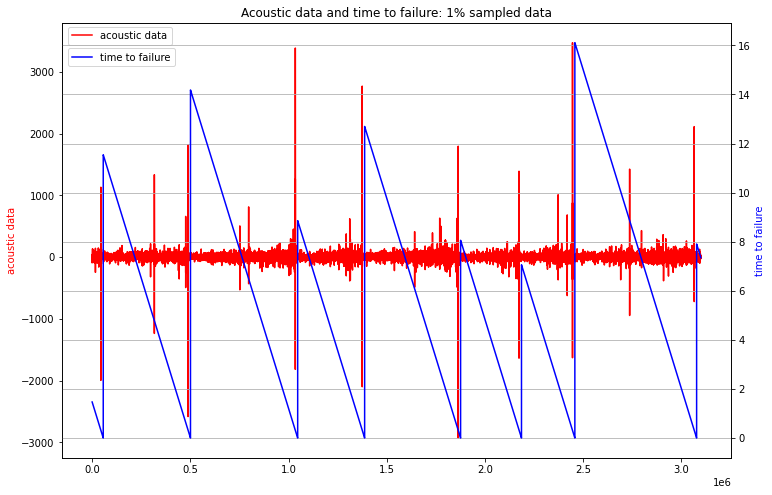

In [70]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [71]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [72]:
train = pd.read_csv('train.csv', iterator=True, chunksize=500_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
X_train.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000,1259.000000000000000
mean,4.519450404530003,7.070487387440785,-252.634630659253389,270.779189833200974,124.395770421010738,0.157750693308943,-10.863415409054806,-2.127879269261319,11.185067513899920,19.957934868943635,285.147736298649704,5.547065082423323,6.296031696798578
std,0.237905933984255,8.074716808717884,460.286461169058725,473.527325161601084,171.056693789335071,0.660832593283517,7.091309607576687,1.527805724558713,1.524542014489533,7.132446329584482,516.407509468531543,0.974709816489687,8.019654140233083
min,3.683130000000000,3.129908499392663,-5515.000000000000000,61.000000000000000,11.355460718036113,-5.672004311083636,-71.000000000000000,-12.000000000000000,9.000000000000000,11.000000000000000,61.000000000000000,4.295094000000000,2.832244755175779
25%,4.365570999999999,4.622520293294905,-229.000000000000000,136.000000000000000,47.968197989649141,-0.018401937007393,-14.000000000000000,-3.000000000000000,10.000000000000000,15.000000000000000,140.000000000000000,5.089983000000000,4.004867271527838
50%,4.523152000000000,5.808514564697836,-164.000000000000000,180.000000000000000,74.963281700389047,0.114269396790046,-10.000000000000000,-2.000000000000000,11.000000000000000,19.000000000000000,187.000000000000000,5.408674000000000,4.971917302110255
75%,4.682301000000001,7.056082262667003,-121.000000000000000,248.500000000000000,122.875982635836394,0.296055310749518,-6.000000000000000,-1.000000000000000,12.000000000000000,23.000000000000000,257.500000000000000,5.779703000000000,6.083462759705839
max,5.239424000000000,84.339035816837665,-51.000000000000000,5444.000000000000000,1798.879368022923245,6.576197567919642,-2.000000000000000,0.000000000000000,22.000000000000000,82.000000000000000,5515.000000000000000,14.125261999999999,83.379727411907282


In [73]:
print("X_train size: " + str(X_train.size))
X_train.head(10)

X_train size: 16367


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.839246,6.268216551185949,-154.0,181.0,57.793102436161561,0.255465224549587,-12.0,-2.0,12.0,22.0,181.0,5.836218,5.352324611907755
1,4.913250,6.491272041035211,-199.0,197.0,80.074400643649426,0.294920103344279,-12.0,-2.0,12.0,22.0,199.0,5.900070,5.609437665816588
2,4.662692,6.755888586795758,-156.0,168.0,61.845006584010456,-0.053888668128535,-13.0,-3.0,12.0,23.0,168.0,5.809660,5.799185627784982
3,4.470258,10.320185871674447,-478.0,410.0,298.288864463353946,-0.621524437184128,-17.0,-4.0,13.0,26.0,478.0,6.203418,9.381205206757727
4,4.638280,5.869340639281305,-129.0,139.0,43.224381646547855,-0.127484467295601,-11.0,-2.0,12.0,20.0,139.0,5.584612,4.977438132135519
5,4.470372,6.913144419491577,-189.0,145.0,41.030285125883999,0.000749004301817,-16.0,-3.0,12.0,24.0,189.0,5.788112,5.854359403257034
6,4.531446,9.879797688712495,-595.0,313.0,303.934946459413027,-1.958447362080814,-18.0,-4.0,13.0,27.0,595.0,6.230774,8.906280031784986
7,4.516792,6.127963212406081,-106.0,131.0,32.848256404357421,0.074349220490721,-13.0,-3.0,12.0,22.0,131.0,5.620204,5.134844470053545
8,4.505324,75.488703981085010,-4621.0,3252.0,746.854418981287836,-1.566024792003907,-47.0,-6.0,15.0,55.0,4621.0,11.765608,74.702159307583258
9,4.345328,6.721713095280837,-247.0,220.0,83.315490427282299,-0.100838466712779,-13.0,-3.0,12.0,22.0,247.0,5.565804,5.751965229709930


In [74]:
print("y_train size: " + str(y_train.size))
y_train.head(10)

y_train size: 1259


0    1.33929966750
0    1.20949935070
0    1.07969903390
0    0.94989871712
0    0.82009840032
0    0.69029808352
0    0.56049776672
0    0.43069744992
0    0.30089713312
0    0.17109681632
dtype: float64

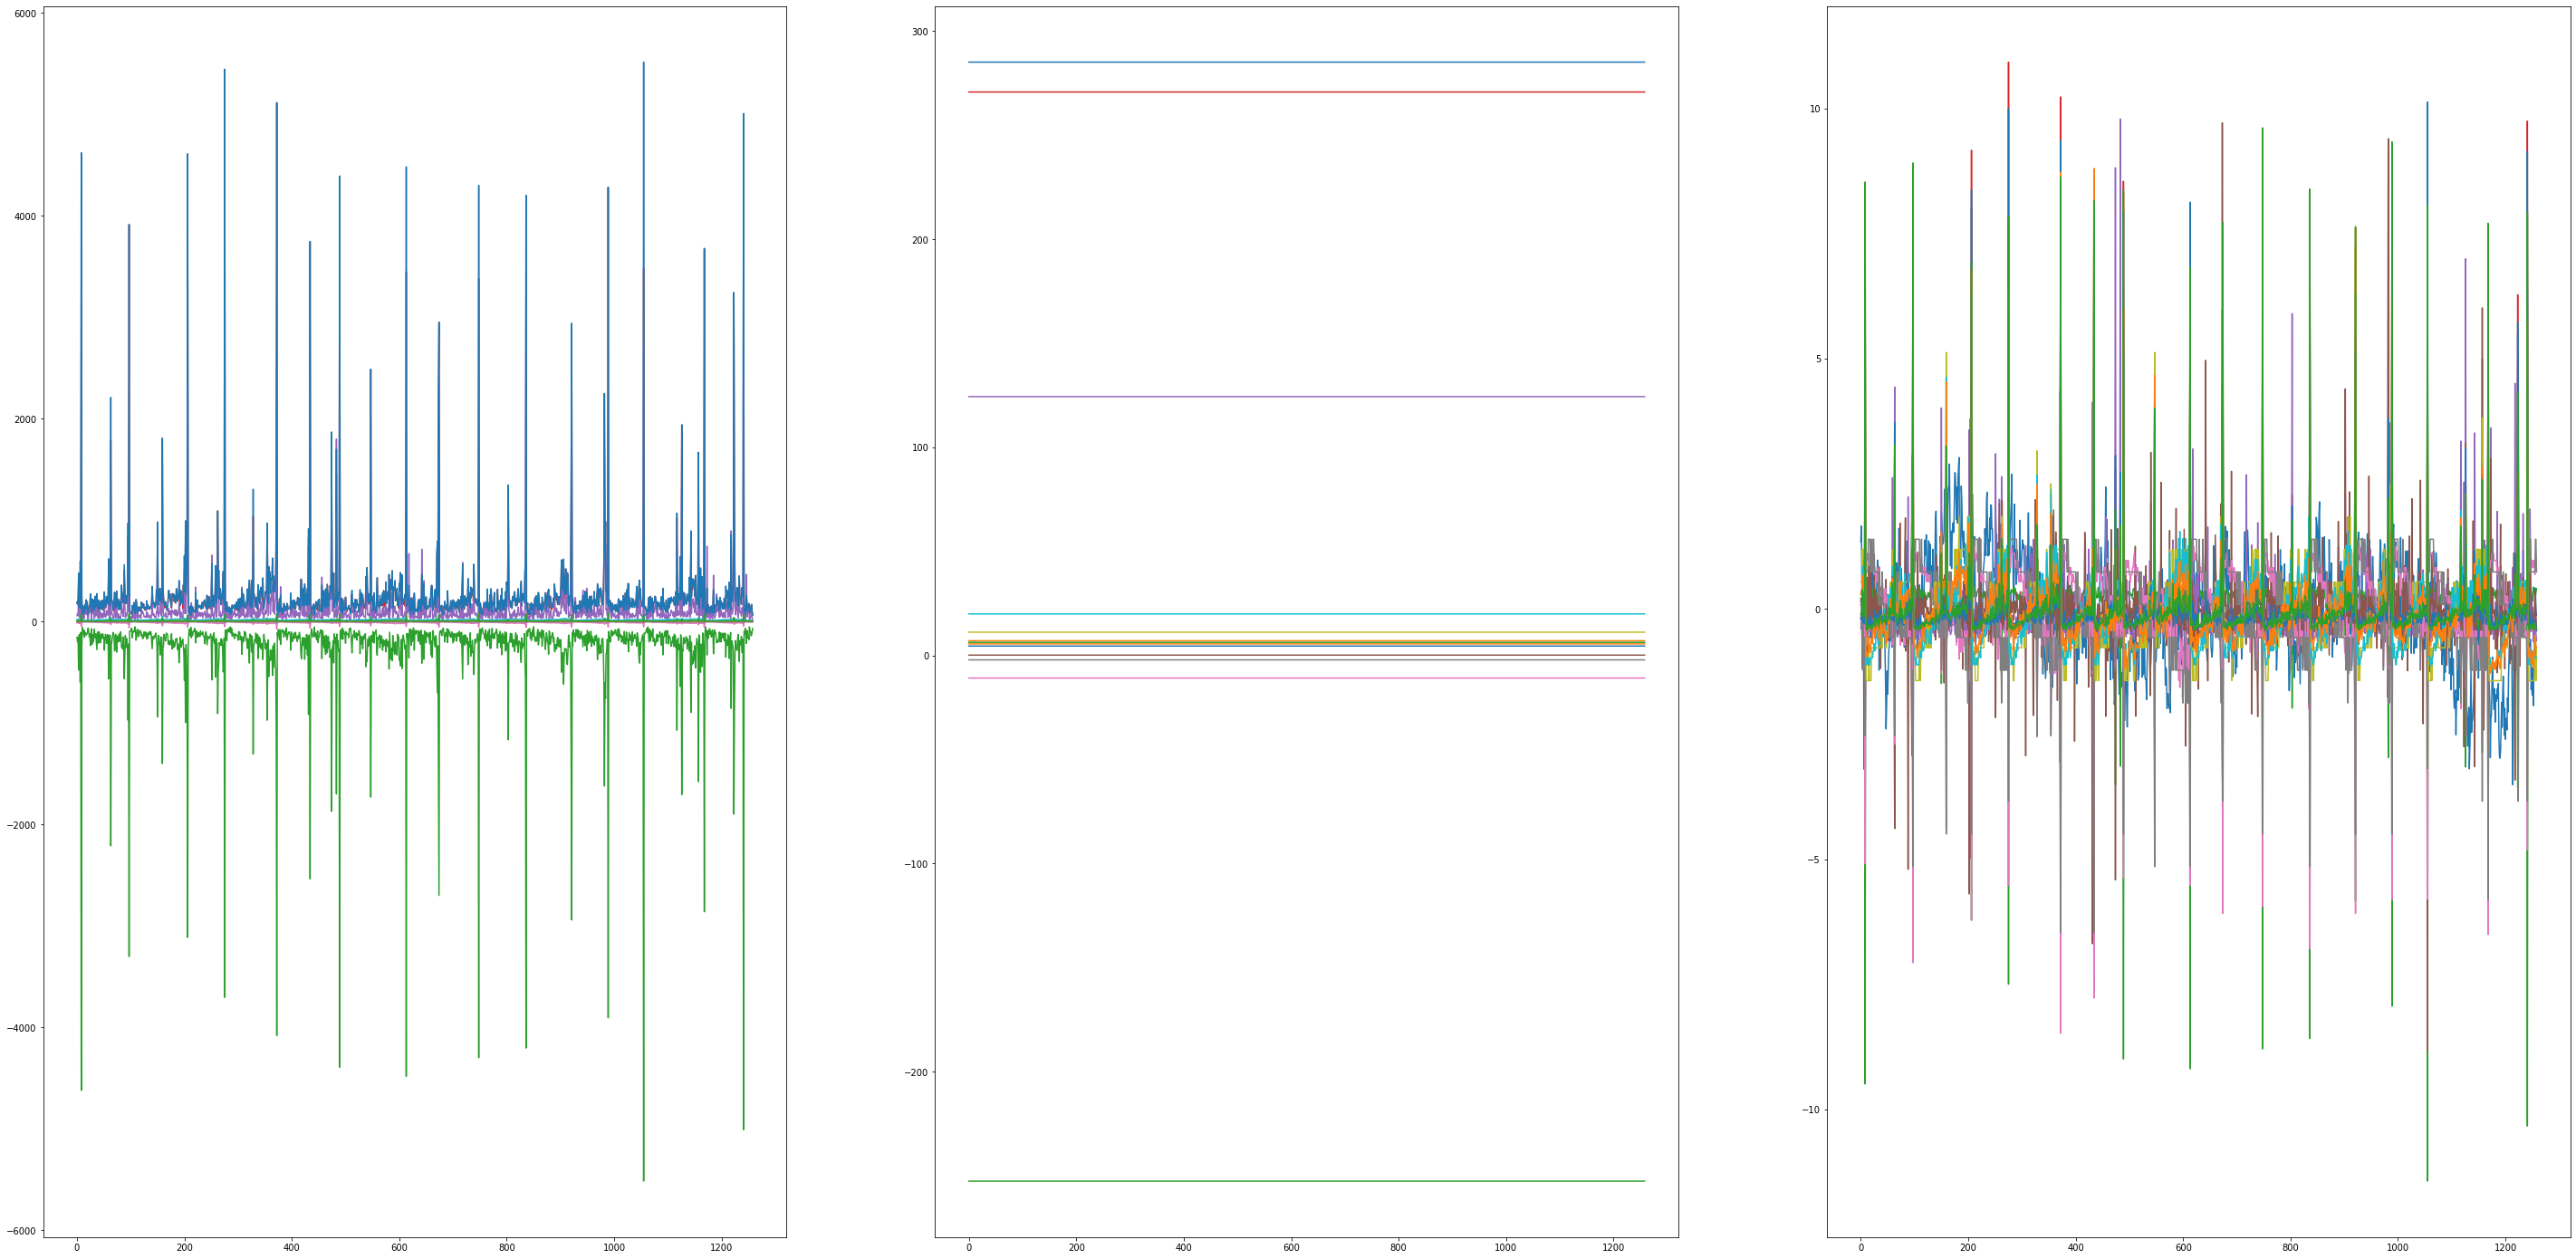

In [75]:
f = plt.figure(figsize=(50,25))
f.add_subplot(1, 3, 1)
plt.plot(X_train.values)
f.add_subplot(1, 3, 2)
plt.plot([X_train.mean()] * len(X_train))
f.add_subplot(1, 3, 3)
plt.plot(((X_train-X_train.mean())/X_train.std()).values)

In [86]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000000000000,0.013122966163653,-0.012376027749479,0.022282060958573,0.016027471915076,-0.006268720572938,0.034741707241784,0.167609481469283,0.153355142521779,0.037041968675479,0.020681458694128,0.200598547467032,0.015617486556899
1,0.013122966163653,1.000000000000000,-0.964713687035792,0.966102590556892,0.626976087259739,0.112406681946976,-0.863944134094497,-0.719858647749759,0.727751838262045,0.863947112526615,0.971709071308278,0.941128150100829,0.999646890747361
2,-0.012376027749479,-0.964713687035792,1.000000000000000,-0.957243207865503,-0.723254872756210,-0.028847382763655,0.795175374073122,0.649767200679850,-0.656158719210883,-0.793367426417966,-0.984635869726125,-0.880680726549803,-0.966563842125311
3,0.022282060958573,0.966102590556892,-0.957243207865503,1.000000000000000,0.727792375725053,0.215533985743824,-0.807142171800068,-0.666913498365547,0.676406810865233,0.807454915106962,0.988577442612796,0.891413105580311,0.967889430722131
4,0.016027471915076,0.626976087259739,-0.723254872756210,0.727792375725053,1.000000000000000,0.152328914967142,-0.533302804660795,-0.466045158735721,0.470373806350399,0.532335575082746,0.728979109907515,0.577086607222284,0.629694736373950
5,-0.006268720572938,0.112406681946976,-0.028847382763655,0.215533985743824,0.152328914967142,1.000000000000000,-0.108195530967454,-0.116030052791832,0.122563941780222,0.105226517992919,0.129833220700466,0.111544233088233,0.112851217977271
6,0.034741707241784,-0.863944134094497,0.795175374073122,-0.807142171800068,-0.533302804660795,-0.108195530967454,1.000000000000000,0.942673556982616,-0.934531062949783,-0.995445969350559,-0.805381839903305,-0.942029983441924,-0.850999386996668
7,0.167609481469283,-0.719858647749759,0.649767200679850,-0.666913498365547,-0.466045158735721,-0.116030052791832,0.942673556982616,1.000000000000000,-0.912654466741530,-0.930797705321645,-0.659012531320759,-0.819218179747665,-0.703200540266917
8,0.153355142521779,0.727751838262045,-0.656158719210883,0.676406810865233,0.470373806350399,0.122563941780222,-0.934531062949783,-0.912654466741530,1.000000000000000,0.945440168386939,0.667874190594845,0.887202809404684,0.711888751729663
9,0.037041968675479,0.863947112526615,-0.793367426417966,0.807454915106962,0.532335575082746,0.105226517992919,-0.995445969350559,-0.930797705321645,0.945440168386939,1.000000000000000,0.805036626695994,0.956349918708789,0.851183685827262


In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

## **Catboost regressor**

In [ ]:
#Model #1 - Catboost 6min
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

parameters = [{'loss_function':['MAE', 'RMSE', 'MAPE'], 'iterations': [10, 20, 50, 100, 200, 500]}]

model = CatBoostRegressor()

model_catboostreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_catboostreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred_catboost = model_catboostreg.predict(X_train_scaled)



In [79]:
print("Best CV score: {:.4f}".format(model_catboostreg.best_score_))
print(model_catboostreg.best_params_)

Best CV score: -2.0687
{'iterations': 100, 'loss_function': 'MAE'}


## **Adaboost regressor**

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

parameters = [{'n_estimators':[5, 10, 20, 50, 100, 200], 'loss': ["linear", "square", "exponential"]}]

model = AdaBoostRegressor()

model_adaboostreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_adaboostreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred_adaboost = model_adaboostreg.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_adaboostreg.best_score_))
print(model_adaboostreg.best_params_)

Best CV score: -2.1802
{'loss': 'exponential', 'n_estimators': 5}


In [ ]:
print(y_pred_adaboost)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred_adaboost)
print(f'Score: {model_score:0.3f}')

[5.29292653 4.15193329 2.98669735 ... 8.16617683 8.99196324 7.65355782]
Score: 2.171


## **Bagging regressor**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

parameters = [{'n_estimators':[10, 20, 50, 100, 200, 500]}]

model = BaggingRegressor()

model_baggreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_baggreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred_baggreg = model_baggreg.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_baggreg.best_score_))
print(model_baggreg.best_params_)

Best CV score: -2.3134
{'n_estimators': 500}


In [ ]:
print(y_pred_baggreg)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred_baggreg)
print(f'Score: {model_score:0.3f}')

[2.68121219 2.14935946 2.47721122 ... 9.60005282 9.1951659  8.63512808]
Score: 0.804


## **SVR**

In [77]:
#Model #1 - Support Vector Machine w/ RBF + Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR

model = SVR(kernel='rbf', tol=0.01)
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

model_SVR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_SVR.fit(X_train_scaled, y_train.values.flatten()) # it takes 3 minutes to fit
y_pred_svr = model_SVR.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_SVR.best_score_))
print(model_SVR.best_params_)

Best CV score: -2.0385
{'C': 2, 'gamma': 0.01}


In [ ]:
print(y_pred_svr)
model_score = mean_absolute_error(y_train.values.flatten(), y_pred_svr)
print(f'Score: {model_score:0.3f}')

[5.0946711  4.17278294 2.43113838 ... 7.63276908 9.49076648 8.39964459]
Score: 2.094


## **NuSVR**

In [ ]:
from sklearn.svm import NuSVR

model = NuSVR(kernel='rbf')
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

model_regNuSVR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_regNuSVR.fit(X_train_scaled, y_train.values.flatten()) # it takes 20 minutes to fit
y_pred_NuSVR = model_regNuSVR.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_regNuSVR.best_score_))
print(model_regNuSVR.best_params_)

Best CV score: -2.1688
{'C': 2, 'gamma': 0.02, 'nu': 0.8}


In [ ]:
print(y_pred_NuSVR)
model_score = mean_absolute_error(y_train.values.flatten(), y_pred_NuSVR)
print(f'Score: {model_score:0.3f}')

[5.14897614 4.27571579 2.5105736  ... 7.72849566 9.46847706 8.40819356]
Score: 2.102


## **Random forest regressor**

In [ ]:
#Model #2 - Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

model_randforest = GridSearchCV(model, parameters, cv=5)
model_randforest.fit(X_train_scaled, y_train.values.flatten()) #it takes 14minutes to fit
y_pred_randforest = model_randforest.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_randforest.best_score_))
print(model_randforest.best_params_)


Best CV score: 0.3569
{'n_estimators': 500}


In [ ]:
print(y_pred_randforest)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred_randforest)
print(f'Score: {model_score:0.3f}')

[2.87309544 2.12809609 2.52780544 ... 9.44135742 9.19851555 8.7251043 ]
Score: 0.806


## **Kernel Ridge Regressor**

In [ ]:
# another method is KernelRidge Regressor

from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(kernel='rbf')

parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

model_KRR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error') #neg_mean_absolute_error
model_KRR.fit(X_train_scaled, y_train.values.flatten()) # it takes 5 minutes to fit
y_pred_krr = model_KRR.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_KRR.best_score_))
print(model_KRR.best_params_)

Best CV score: -2.2046
{'alpha': 0.1, 'gamma': 0.012}


In [ ]:
print(y_pred_krr)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred_krr)
print(f'Score: {model_score:0.3f}')

[5.15135911 4.40527502 2.95736361 ... 7.90833572 9.87272368 8.64438996]
Score: 2.110


## **Predicting vs actual**

<Figure size 432x288 with 0 Axes>

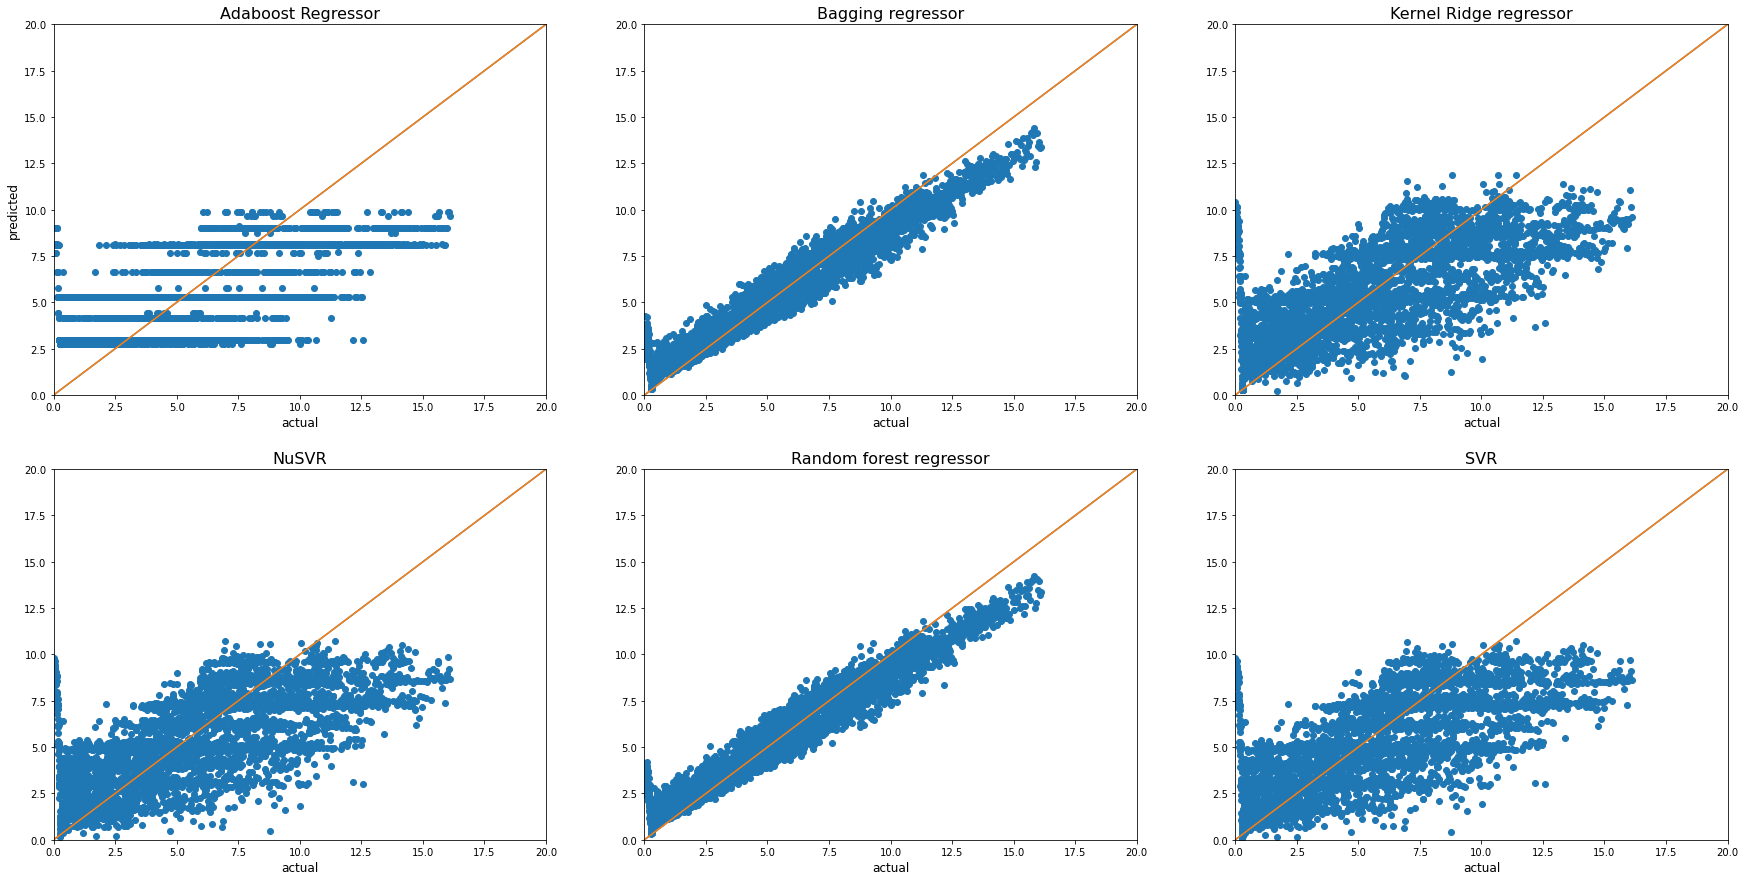

In [ ]:
plt.tight_layout()
f = plt.figure(figsize=(30, 15))
f.add_subplot(2, 3, 1)
plt.scatter(y_train.values.flatten(), y_pred_adaboost)
plt.title('Adaboost Regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot()
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(2, 3, 2)
plt.scatter(y_train.values.flatten(), y_pred_baggreg)
plt.title('Bagging regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(2, 3, 3)
plt.scatter(y_train.values.flatten(), y_pred_krr)
plt.title('Kernel Ridge regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(2, 3, 4)
plt.scatter(y_train.values.flatten(), y_pred_NuSVR)
plt.title('NuSVR', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(2, 3, 5)
plt.scatter(y_train.values.flatten(), y_pred_randforest)
plt.title('Random forest regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(2, 3, 6)
plt.scatter(y_train.values.flatten(), y_pred_svr)
plt.title('SVR', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

## **Predicting vs actual**

NameError: ignored

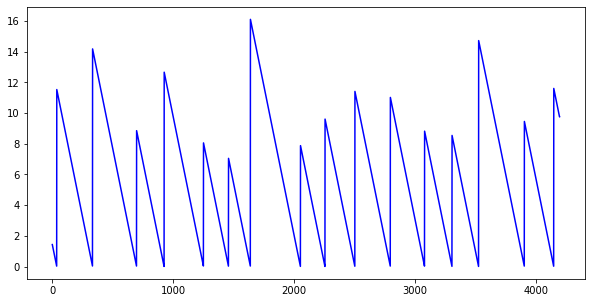

In [32]:
# second plot
f.add_subplot(2, 3, 1)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred_adaboost, color='orange', label='Adaboost')
plt.legend()
plt.title('Adaboost predictions vs actual')

# third plot
f.add_subplot(2, 3, 2)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred_krr, color='orange', label='KernelRidge')
plt.legend()
plt.title('Kernel Ridge predictions vs actual')

# third plot
f.add_subplot(2, 3, 3)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred_randforest, color='orange', label='Random Forest Regressor')
plt.legend()
plt.title('Random Forest predictions vs actual')

# third plot
f.add_subplot(2, 3, 4)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred_baggreg, color='orange', label='Bagging Regressor')
plt.legend()
plt.title('Bagging predictions vs actual')

# third plot
f.add_subplot(2, 3, 5)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred_NuSVR, color='orange', label='NuSVR Regressor')
plt.legend()
plt.title('NuSVR predictions vs actual')

# third plot
f.add_subplot(2, 3, 6)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred_svr, color='orange', label='SVR')
plt.legend()
plt.title('SVR predictions vs actual')

In [ ]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [ ]:
submission.head(10)

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0
seg_004314,0
seg_004cd2,0
seg_004ee5,0
seg_004f1f,0


In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.double, index=submission.index)

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [ ]:
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

print(submission['time_to_failure'])
print(model_regNuSVR.predict(X_test_scaled))
#submission['time_to_failure'] = model_regNuSVR.predict(X_test_scaled)
#submission.to_csv('submission.csv')